# Processing data through July 2017

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import scipy.ndimage
import skimage.io
import skimage.measure
import skimage.morphology
import skimage.segmentation
import skimage.filters
import scipy.ndimage

import pandas as pd
import xmltodict
import json
import glob
import sys
sys.path.insert(0, '../')
import mscl_utils as mscl
colors = mscl.set_plotting_style()
%matplotlib inline

## Status of data
HJ gave me a bunch of data covering a wide range of MscL expression constructs. 


## Things to tidy-up and finish. 
There are still a bunch of things I need to finish with the code to make things ready for a pipeline. 

1. Fix the metadata parsing function to extract the correct exposure times. Right now, it's pulling the brightfield exposure times for the fluorescence channel. Maybe here I can use some random package from the internet to scrape image metadata files. 

2. Include a distance filter for the centroid-click pairing scheme. Right now, if a cell is lost it will match it up withi whatever is the closest click position. I think including a maximum distance filter would be sufficient. 

3. **(Optional)** Improve segmentation to isolate single-cells. 

##  Relevant Functions
Below are the functions I've written this far for segmentation and survival tracking analysis. Whatever functions are here are what I used for the analysis in this notebook.  

In [34]:
def contour_seg(image, level=0.3, selem='default', perim_bounds=(5, 25),
                ip_dist=0.160, return_conts=False):
    """
    Identifies contours around dark objects in a phase contrast image.

    Parameters
    ----------
    image: 2d-array
        Phase contrast image of interest. This shoul
    level: float
        Level at which to draw contours on black top-hat filtered image.
        Default value is 0.3.
    selem: 2d-array or string
        Structuring element to use for the black top-hat filtering procedure
        Default value is a disk with a diameter of 20 pixels.
    perim_bounds: length 2 tuple
        Lower and upper perimeter bounds of approved objects. This should be
        in units of microns. The default values are 5 and 25 microns for the
        lower and upper bound, respectively.
    ip_dist : float
        Interpixel distance of the image in units of microns per pixel. The
        default value is 0.160 microns per pixel.
    return_conts : bool
        If True, the x and y coordinates of the individual contours will be
        returned. Default value is False

    Returns
    -------
    im_lab : 2d-array, int
        Two dimensional image where each individual object is labeled.

    conts : 1d-array
        List of contour coordinates. Each entry of this array comes as
        an x,y pair of arrays. Has the same length as the number of
        contoured objects. This is only returned if `return_conts` is
        True.

    """

    # Apply the white top-hat filter.
    if selem == 'default':
        selem = skimage.morphology.disk(20)

    # Normalize the image.
    image = (image - image.min()) / (image.max() - image.min())

    # Blur and background subtract the image.
    im_blur = skimage.filters.gaussian(image, sigma=5)
    im_sub = image - im_blur

    # Apply the black tophat filter.
    im_filt = skimage.morphology.black_tophat(im_sub, selem)

    # Find the contours and return.
    conts = skimage.measure.find_contours(im_filt, level)

    # Make an empty image for adding the approved objects.
    objs = np.zeros_like(image)

    # Loop through each contour.
    for _, c in enumerate(conts):
        perim = 0
        for j in range(len(c) - 1):
            # Compute the distance between points.
            distance = np.sqrt((c[j+1, 0] - c[j, 0])**2 +
                               (c[j+1, 1] - c[j, 1])**2)
            perim += distance * ip_dist

        # Test if the perimeter is allowed by the user defined bounds.
        if (perim > perim_bounds[0]) & (perim < perim_bounds[1]):

            # Round the contours.
            c_int = np.round(c).astype(int)

            # Color the image with the contours and fill.
            objs[c_int[:, 0], c_int[:, 1]] = 1.0

    # Fill and label the objects.
    objs_fill = scipy.ndimage.binary_fill_holes(objs)
    objs_fill = skimage.morphology.remove_small_objects(objs_fill)
    objs_border = skimage.segmentation.clear_border(objs_fill)
    im_lab = skimage.measure.label(objs_border)
    if return_conts is True:
        return conts, im_lab
    else:
        return im_lab


def marker_parse(fname, type_dict={1: False, 2: True}):
    """
    Parses the XML file produced from the CellCounter ImageJ plugin and
    packages the marker positions and type into a Pandas DataFrame.

    Parameters
    ----------
    fname : str
        Path to the XML file of interest.
    type_dict : dict
        Dictionary of types and survival. Default is assigning type 1
        as death and type 2 as survival.

    Returns
    -------
    df : Pandas DataFrame
        Data frame containing x and y positions of markers as well as
        the type classification.
    """
    with open(fname, 'r') as f:
        positions = xmltodict.parse(f.read())

    # Extract only the marker data.
    markers =  positions['CellCounter_Marker_File']['Marker_Data']['Marker_Type']

    # Find the total number of types and loop through them to make data frames.
    dfs = []
    num_types = len(markers)
    for i in range(num_types):
        try:
            type_marks = markers[i]['Marker']
            _df = pd.DataFrame(type_marks)
            # Insert a column keeping track of the type
            _df.insert(0, 'survival', type_dict[int(markers[i]['Type'])])
            dfs.append(_df)
        except:
            pass

    # Concatenate the data frames ignorning indexing.
    df = pd.concat(dfs, axis=0, ignore_index=True)

    # Clean up the data frame and return.
    df.drop('MarkerZ', 1, inplace=True)
    df.columns = ['survival', 'x_pos', 'y_pos']
    df['x_pos'] = df['x_pos'].astype(int)
    df['y_pos'] = df['y_pos'].astype(int)
    return df


def link_markers(markers, seg_mask, fluo_image, ip_dist=0.160,
                 return_coords=False, inplace=False,
                 position_labels=('x_pos', 'y_pos')):
    """
    Maps markers from one image to centroids of segmented objects from
    another. This assumes a marker belongs to the object with the minimum
    marker-centroid distance.

    Parameters
    ----------
    markers : Pandas DataFrame
        DataFrame containing the x and y positions of the markers.
    seg_mask : 2d-array, int
        Labeled segmentation mask. The coordinates of the object centroids
        will be calculated from this image.
    fluo_image : 2d-array, float or int
        The fluorescence image used to extract intensities. If None, no
        intensity information will be returned. These intensity values
        will be returned as an intensity per square physical distance
        as given by `ip_dist`.
    ip_dist :  float
        Interpixel distance for the image. Default value is 0.160 microns
        per pixel.
    return_coords : bool
        If True, the paired coordinates will be returned as a tuple. It
        will have the form ((mark_x, mark_y), (cent_x, cent_y)). Default
        value is False.
    inplace : bool
        If True, the markers DataFrame will be updated in place with the
        paired mask label and intensity if the fluorescence image is given.
    position_labels :  tuple of str
        Labels of position markers in the markers DataFrame in the order
        of x position and y position. Default is `x_pos` and `y_pos`.

   Returns
   -------
   df : Pandas DataFrame
       DataFrame containing survival type, marker positions, mask label,
       area, and intensity if provided. Note this is not returned if
       `in_place = True`.
   coords : list of tuple
       A list of tuples containing the marker x,y positions and the
       coordinates of the associated segmentation centroid. This
       is only returned if `return_coords`==True.

    """
    # Compute the properties from the segmentation mask.
    props = skimage.measure.regionprops(seg_mask, fluo_image)
    area, intensity, labels, centroids = [], [], [], []
    for prop in props:
        area.append(prop.area * ip_dist**2)
        intensity.append(prop.mean_intensity / ip_dist**2)
        labels.append(prop.label)
        centroids.append(prop.centroid)

    # Set up a list to store the coordinates and duplicate the df.
    coords = []
    df = markers.copy(deep=True)

    # Compute the minimum distances.
    for i in range(len(markers)):
        distances = []
        x = markers.iloc[i][position_labels[0]]
        y = markers.iloc[i][position_labels[1]]

        # Loop through each centroid and find the minimum distance.
        for c in centroids:
            distances.append(np.sqrt((x - c[1])**2 + (y - c[0])**2))

        # Find the index with the minimum distance.
        min_ind = np.argmin(distances)
        coords.append(((x, y),
                       (centroids[min_ind][1], centroids[min_ind][0])))

        # Determine if a new DataFrame should be made or not.
        # There should be a better way to do this -- will spruce up later.
        if inplace is False:
            # Update the data frame.
            df.set_value(i, 'mask_label', labels[min_ind])
            df.set_value(i, 'label_cent_x', centroids[min_ind][1])
            df.set_value(i, 'label_cent_y', centroids[min_ind][0])
            df.set_value(i, 'intensity', intensity[min_ind])
            df.set_value(i, 'area', area[min_ind])

        else:
            markers.set_value(i, 'mask_label', labels[min_ind])
            markers.set_value(i, 'label_cent_x', centroids[min_ind][1])
            markers.set_value(i, 'label_cent_y', centroids[min_ind][0])
            markers.set_value(i, 'intensity', intensity[min_ind])
            markers.set_value(i, 'area', area[min_ind])

    # Figure out what to return.
    if inplace is False:
        if return_coords is True:
            return df, coords
        else:
            return df


def scrape_metadata(fname, channels=('Brightfield', 'GFP'), return_date=True):
    """
    Takes an image metadata file and returns the datea nd GFP exposure time.

    Parameters
    ----------
    fname : str
        Pat of the metadata file to parse.
    channel : tuple of str
        The channels from which to scrape the exposure time. A single channel
        name can be given. Default is ('Brightfield', 'GFP').
    return_date : bool
        If True, the date of the acquisition will also be returned.

    Returns
    -------
    exposure: dict or float
        The exposure time of the desired channel. If multiple channels are
        given, this will be a tuple of the exposure times. If return_date is
        True, the date will also be in this dictionary.
   """

    # Open the metadata file.
    with open(fname, 'r') as f:
        metadata = json.load(f)

    

    # Get a list of the keys in the metadata file.
    keys = metadata.keys()

    # Determine if a single channel or multiple channel exposures are desired.
    if (type(channels) != tuple) & (type(channels) != str):
        raise TypeError('desired channels must be a tuple or a string.')
    else:
        if type(channels) == str:
            num_channels = 1
            channels = (channels)
            exposure = None
        else:
            num_channels = len(channels)
            exposure = []

    # Loop through each desired channel and scrape the exposure.
    for i in range(num_channels):
        for k in keys:
            try:
                chan = metadata[k]['Channel']
                if chan.lower() == channels[i].lower():
                    _exposure = metadata[k]['Exposure-ms']
                if num_channels == 1:
                    exposure = _exposure
                else:
                    if i == 0:
                        exposure = {channels[i] + '_exp_ms': _exposure}
                    else:
                        exposure[channels[i] + '_exp_ms'] = _exposure
            except:
                pass

    if return_date is True:
        # Get the date from the Summary field.
        date = metadata['Summary']['Date'].split('-')
        date = ''.join(date)
        exposure['date'] = date
    return exposure


def save_seg(fname, image, mask, fill_contours=True, ip_dist=0.160,
             bar_length=10, title=None, colormap='hls'):
    """
    Saves a merge of a segmentation mask and the original image for a
    sanity check.

    Parameters
    ----------
    fname : str
        The file will be saved with this path.
    image : 2d-array, float
        The original image on which the segmentation mask will be overlaid.
    mask : 2d-array, bool
        Boolean segmentation mask of the original image.
    contours: bool
        If True, contours of segmented objects will be filled.
    ip_dist : float
        Interpixel distance for the image. This is used for computing the
        scalebar length.  This should be in units of microns. Default
        value is 0.160 microns per pixel.
    bar_length : int
        The length of the desired scalebar in units of microns.
    title : str, optional
        Title for the image.
    colormap : str
        Colormap for labeling the objects. Default is the high-contrast
        'hls'. This can take any standard colormap string.

    Return
    ------
    fig : Matplotlib Figure object
        Figure containing the axis of the plotted image.
    """

    # Make copies of the image and mask.
    image_copy = np.copy(image)
    mask_copy = np.copy(mask)

    # Burn the scalebar into the upper-left hand  of th image.
    num_pix = int(bar_length / ip_dist)
    image = (image_copy - image_copy.min()) /\
            (image_copy.max() - image_copy.min())
    image[10:20, 10:10 + num_pix] = 1.0

    # Make sure the mask is a boolean image.
    if type(mask) != bool:
        mask = mask_copy > 0

    # Find the contours of the mask.
    conts = skimage.measure.find_contours(mask, 0)

    # Plot the image and generate the contours.
    with sns.axes_style('white'):
        fig = plt.figure()
        plt.imshow(image, cmap=plt.cm.Greys_r)

        # Plot all of the contours
        colors = sns.color_palette(colormap, n_colors=len(conts))
        for i, c in enumerate(conts):
            plt.plot(c[:, 1], c[:, 0], color=colors[i], lw=0.75)
            if fill_contours is True:
                plt.fill(c[:, 1], c[:, 0], color=colors[i], alpha=0.5)

        # Remove the axes.
        plt.xticks([])
        plt.yticks([])

        # Add title if provided.
        if title is not None:
            plt.title(title)

        # Tighten up and save the image.
        plt.tight_layout()
        plt.savefig(fname, bbox_inches='tight')
        plt.close()
    return fig


def show_connections(fname, image, data, title=None, bar_length=10,
                     ip_dist=0.16):
    """
    Saves the original phase contrast image with the segmented
    centroids and the manually recorded markers linked by lines.

    Parameters
    ----------
    fname : str
        Filename to save the image wish shown connections between
        segmented object centroids and the markers.
    image : 2d-array
        Original phase contrast image over which the points will
        be drawn
    data : Pandas DataFrame
        DataFrame containing the marker x and y positions and the
        centroid x and y positions.
    title : str
        Title to be applied to the image. If not specified, none will
        be included.
    bar_length : int
        Length of the scalebar in units of microns. Default value
        is 10.
    ip_dist : float
        Interpixel distance of the image. This should be in units of
        microns per pixel. Default value is 0.16 microns per pixel.

    Returns
    -------
    fig : Matplotlib Figure Canvas
        Figure canvas of the plot.
    """
    # Add the scale bar to the image.
    if image.max() > 1:
        image = (image - image.min()) / (image.max() - image.min())
    num_pix = int(bar_length / ip_dist)
    image_copy = np.copy(image)
    image_copy[10:20, 10:10 + num_pix] = 1.0

    # Define the colors for survivors and corpses.
    colors = {False: '#D56C55', True: '#08AADE'}

    # Group the DataFrame by survival.
    grouped = pd.groupby(data, 'survival')

    # Show the image
    with sns.axes_style('white'):
        fig = plt.figure()
        plt.imshow(image_copy, cmap=plt.cm.Greys_r)
        plt.plot([], [], '-o', ms=3, lw=1, color=colors[True],
                 label='survivor')
        plt.plot([], [], '-o', ms=3, lw=1, color=colors[False], label='goner')
        plt.legend(loc='lower left')
        for g, d in grouped:
            for i in range(len(d)):
                # Parse the positions
                m_x = d.iloc[i]['x_pos']
                m_y = d.iloc[i]['y_pos']
                c_x = d.iloc[i]['label_cent_x']
                c_y = d.iloc[i]['label_cent_y']
                # Plot the connections.
                plt.plot((m_x, c_x), (m_y, c_y), '-', ms=3, lw=1,
                         color=colors[g])
                plt.plot(m_x, m_y, 'o', ms=3, lw=1, color=colors[g])
                plt.plot(c_x, c_y, 'o', ms=3, markerfacecolor='w',
                         markeredgecolor=colors[g], markeredgewidth=1)

        # Format the axes
        plt.xticks([])
        plt.yticks([])

        # Add a title if necessary.
        if title is not None:
            plt.title(title, fontsize=12)
        plt.savefig(fname, bbox_inches='tight')
    return fig

##  Performing the processing

Let's start with the SD1 data

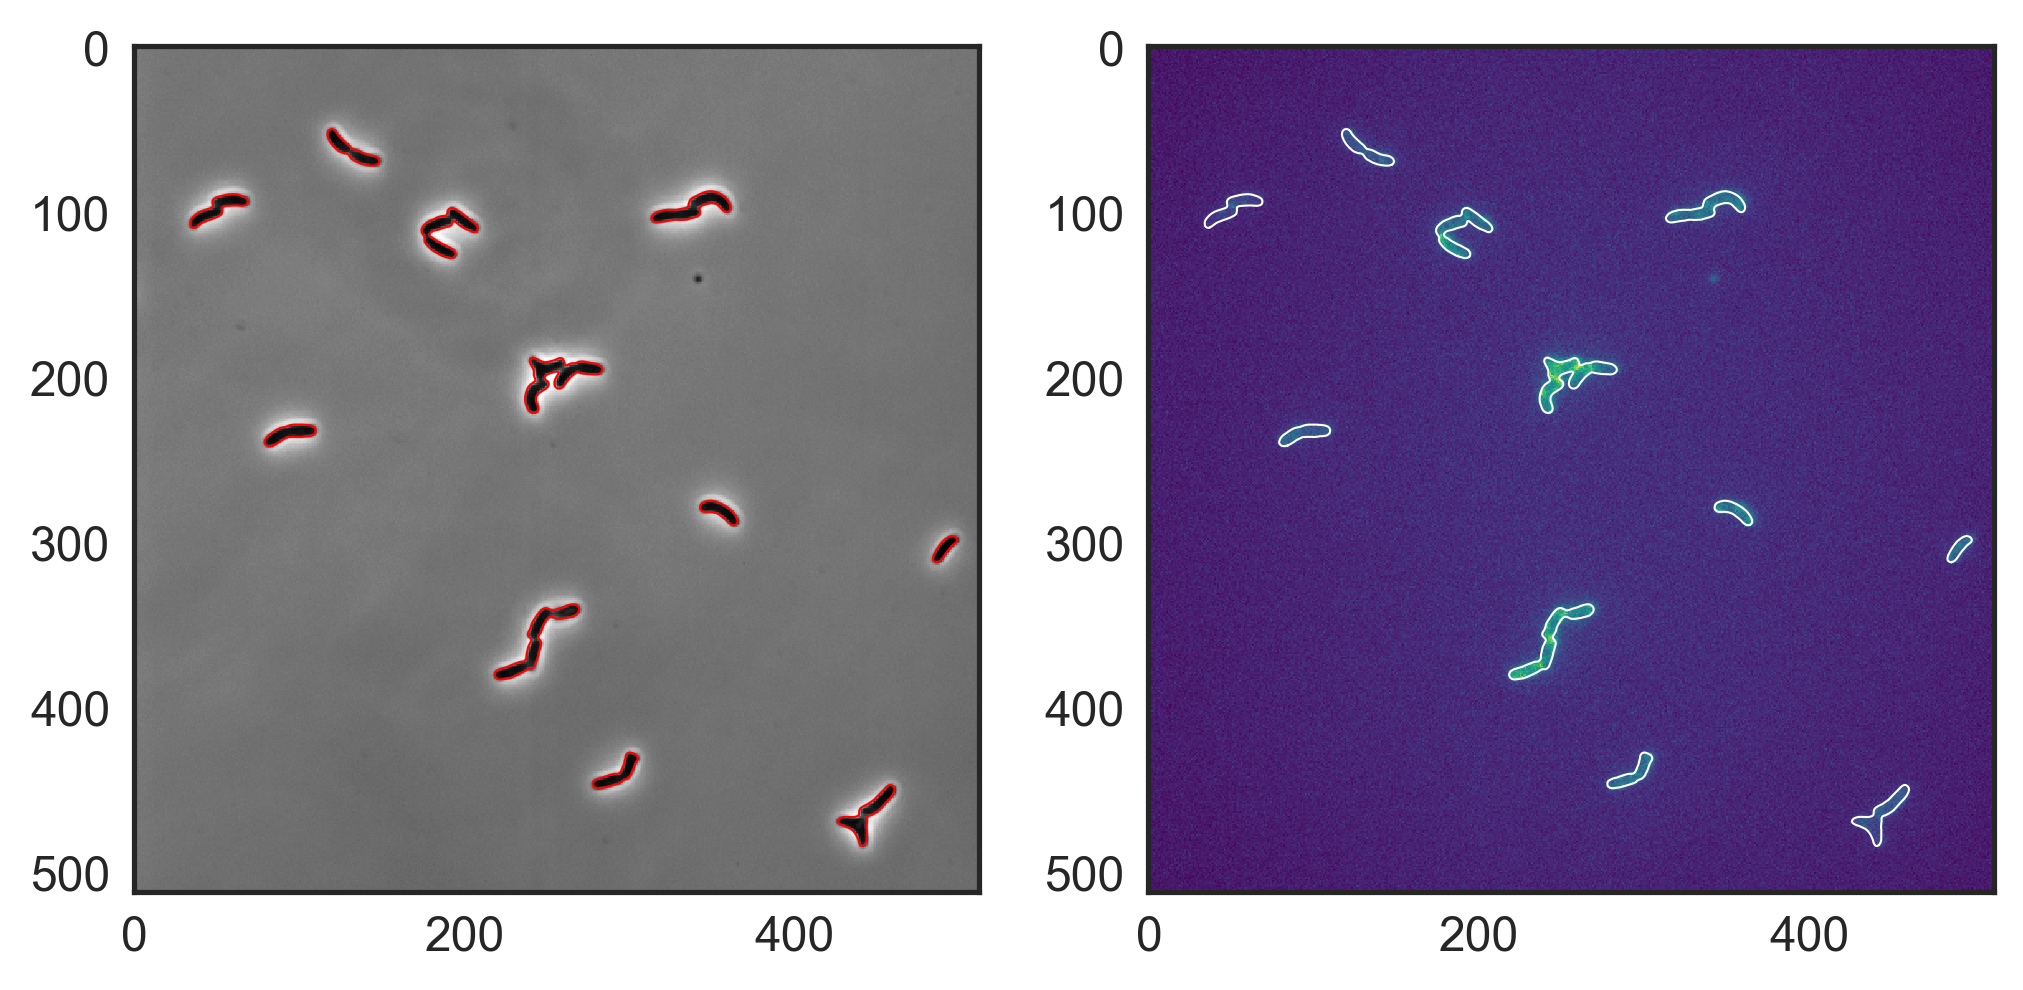

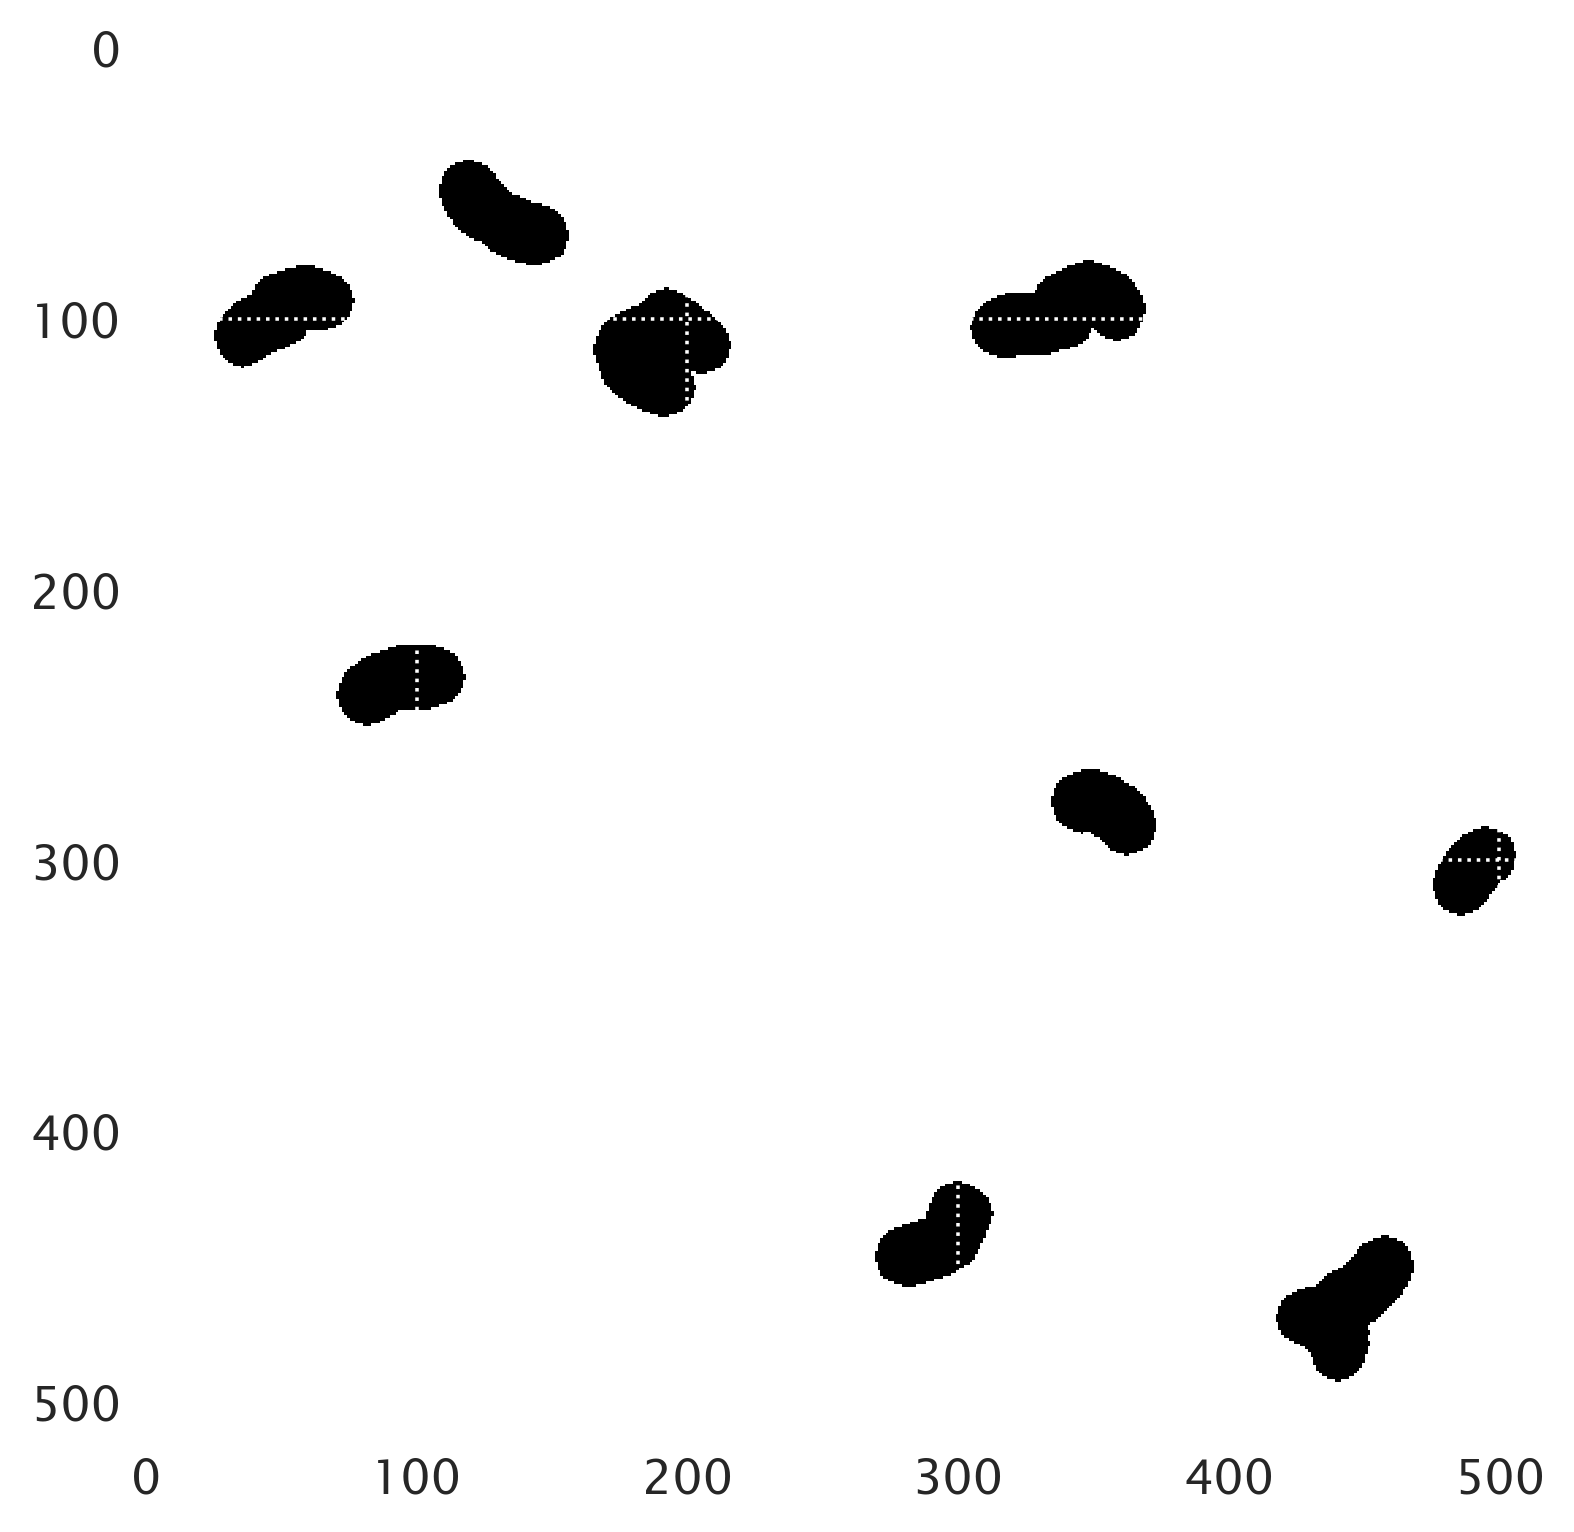

In [88]:
# Grab all of the image files for SD1. 
data_dir = 'data/images/'
sd0_bf_files = glob.glob(data_dir + 'sd0/*/*/*/*Brightfield*.tif')
sd0_gfp_files = glob.glob(data_dir + 'sd0/*/*/*/*GFP*.tif')

# # Make sure everything is working OK with a single image file.

im_phase = skimage.io.imread(sd0_bf_files[0])
im_gfp = skimage.io.imread(sd0_gfp_files[0])

# Pass the phase image through the contour segmentation function. 
conts, im_seg = contour_seg(im_phase, return_conts=True)

with sns.axes_style('white'):
    fig, ax = plt.subplots(1, 2)
    ax[0].imshow(im_phase, cmap=plt.cm.Greys_r)
    ax[1].imshow(im_gfp, cmap='viridis')
    for c in conts:
        ax[1].plot(c[:,1], c[:,0], 'w-', lw=0.5)
        ax[0].plot(c[:,1], c[:,0], 'r', lw=0.5)
        
        
# Perform an ad-hoc bg subtraction. 
obj = im_seg > 0
obj_dil = skimage.morphology.dilation(obj, selem=skimage.morphology.disk(8))
inv_seg = obj_dil < 1
fig, ax = plt.subplots(1,1)
plt.imshow(inv_seg, cmap=plt.cm.Greys_r)

In [73]:
sd0_files

['data/images/sd0/Jul14/SD0_pre_3/Pos0/img_000000000_Brightfield_000.tif',
 'data/images/sd0/Jul14/SD0_pre_3/Pos0/img_000000000_GFP_000.tif',
 'data/images/sd0/Jul14/SD0_pre_3/Pos1/img_000000000_Brightfield_000.tif',
 'data/images/sd0/Jul14/SD0_pre_3/Pos1/img_000000000_GFP_000.tif',
 'data/images/sd0/Jul14/SD0_pre_3/Pos2/img_000000000_Brightfield_000.tif',
 'data/images/sd0/Jul14/SD0_pre_3/Pos2/img_000000000_GFP_000.tif',
 'data/images/sd0/Jul14/SD0_pre_3/Pos3/img_000000000_Brightfield_000.tif',
 'data/images/sd0/Jul14/SD0_pre_3/Pos3/img_000000000_GFP_000.tif',
 'data/images/sd0/Jul14/SD0_pre_3/Pos4/img_000000000_Brightfield_000.tif',
 'data/images/sd0/Jul14/SD0_pre_3/Pos4/img_000000000_GFP_000.tif',
 'data/images/sd0/Jul14/SD0_pre_3/Pos5/img_000000000_Brightfield_000.tif',
 'data/images/sd0/Jul14/SD0_pre_3/Pos5/img_000000000_GFP_000.tif',
 'data/images/sd0/Jul14/SD0_pre_3/Pos6/img_000000000_Brightfield_000.tif',
 'data/images/sd0/Jul14/SD0_pre_3/Pos6/img_000000000_GFP_000.tif',
 'data

Okay, that segmentation actually looks pretty good. HJ didn't give me any marker posisitons with these data sets, so I'm just kind of restricted to grabbing the fluorescence information from each. Before I move on, let's figure out how to get the exposure information in a reliable way. 

In [141]:
folders = ['sd0', 'sd4', 'sd1', '10sd1', 'sd2', '12sd2']
ip_dist = 0.16
dfs = []
for i, f in enumerate(folders):
    # Glob all the file names. 
    if (f == 'sd1') | (f == 'sd4'):
        target = '/*/*/*.tif'
        files = glob.glob(data_dir + f + target)
        files_met = glob.glob(data_dir + f + '/*/*/*metadata.txt')
        print(len(files))
    else:
        target_bf = '/*/*/*/*Brightfield*.tif'
        target_gfp = '/*/*/*/*GFP*.tif'
        files= glob.glob(data_dir + f + target_bf)
        files_gfp = glob.glob(data_dir + f + target_gfp)
        files_met = glob.glob(data_dir + f +'/*/*/*/*metadata.txt')
        print(len(files), len(files_gfp))
     
    # Loop through each image and process
    for j, file in enumerate(files):
        if (f == 'sd1') | (f == 'sd4'):
            im = skimage.io.imread(file)
            im_phase = im[0]
            im_gfp = im[1] 
            name = file.split('/')[-1]

        else:
            im_phase = skimage.io.imread(file)
            im_gfp = skimage.io.imread(files_gfp[j])
            name = file.split('/')[-3]
       
        # Filter the image. 
#         selem = skimage.morphology.square(3)
#         im_gfp = scipy.ndimage.median_filter(im_gfp, footprint=selem)
        

        
        # Determine the sample ID.
        flow_rate = name.split('_')[1]      
        exp = scrape_metadata(fname=files_met[j], return_date=False)
        # Process.
        seg = contour_seg(im_phase) 
        
        # Perform the field bg subtraction. 
        flat_seg = im_seg > 0
        dil_selem = skimage.morphology.disk(8)
        im_dil = skimage.morphology.dilation(flat_seg, dil_selem)
        inv_seg = skimage.measure.label(im_dil < 1)
        inv_props = skimage.measure.regionprops(inv_seg, im_gfp)
        mean_bg = np.mean([prop.mean_intensity for prop in inv_props])
        
        props = skimage.measure.regionprops(seg, im_gfp)
        
        # Convert total
        raw_intensities = np.array([prop.mean_intensity for prop in props])
        sub_intensities = raw_intensities - mean_bg
        areas = [prop.area * ip_dist**2 for prop in props]
        
        # Make a DataFrame of all of the relevant properties.
        df = pd.DataFrame([raw_intensities, sub_intensities, areas]).T
        df.insert(0, 'mean_bg', mean_bg)
        df.insert(0, 'exposure_ms', exp['GFP_exp_ms'])
        df.insert(0, 'flow_rate', flow_rate)
        df.insert(0, 'sd', f) 
        dfs.append(df)
     
# Concatenate all of the DataFrames together. 
data = pd.concat(dfs)
data.columns = ['sd', 'flow_rate', 'exposure_ms', 'mean_bg', 'raw_intensity', 'sub_intensity', 'area']

34 34


/Users/gchure/anaconda/lib/python3.6/site-packages/skimage/morphology/misc.py:122: UserWarning: Only one label was provided to `remove_small_objects`. Did you mean to use a boolean array?
  warn("Only one label was provided to `remove_small_objects`. "


20


/Users/gchure/anaconda/lib/python3.6/site-packages/skimage/external/tifffile/tifffile.py:1752: UserWarning: ome-xml: not an ome-tiff master file
  warnings.warn("ome-xml: not an ome-tiff master file")


60
80 80
120 120
38 38


In [145]:
# Modify the intensities. 
max_exp = data['exposure_ms'].unique().max()
min_exp = data['exposure_ms'].unique().min()
data['scaled_int'] = data['sub_intensity'] *  max_exp / data['exposure_ms']
data['scaled_raw'] = data['raw_intensity'] * max_exp / data['exposure_ms']
mean_wt = data[data['sd']=='sd0']['scaled_int'].mean()
data['rescaled_int'] = data['scaled_raw']  - (data['mean_bg'] * max_exp / data['exposure_ms'])
data['rescaled_bg'] = data['mean_bg'] * max_exp / data['exposure_ms']
data['rel_int'] = data['rescaled_int'] / data[data['sd']=='sd0']['rescaled_int'].mean()

Now the data is processed, although I'm still not 100% sure of the difference in exposure time between them. Ofr right now, we can just group them by SD and jitter plot them. 

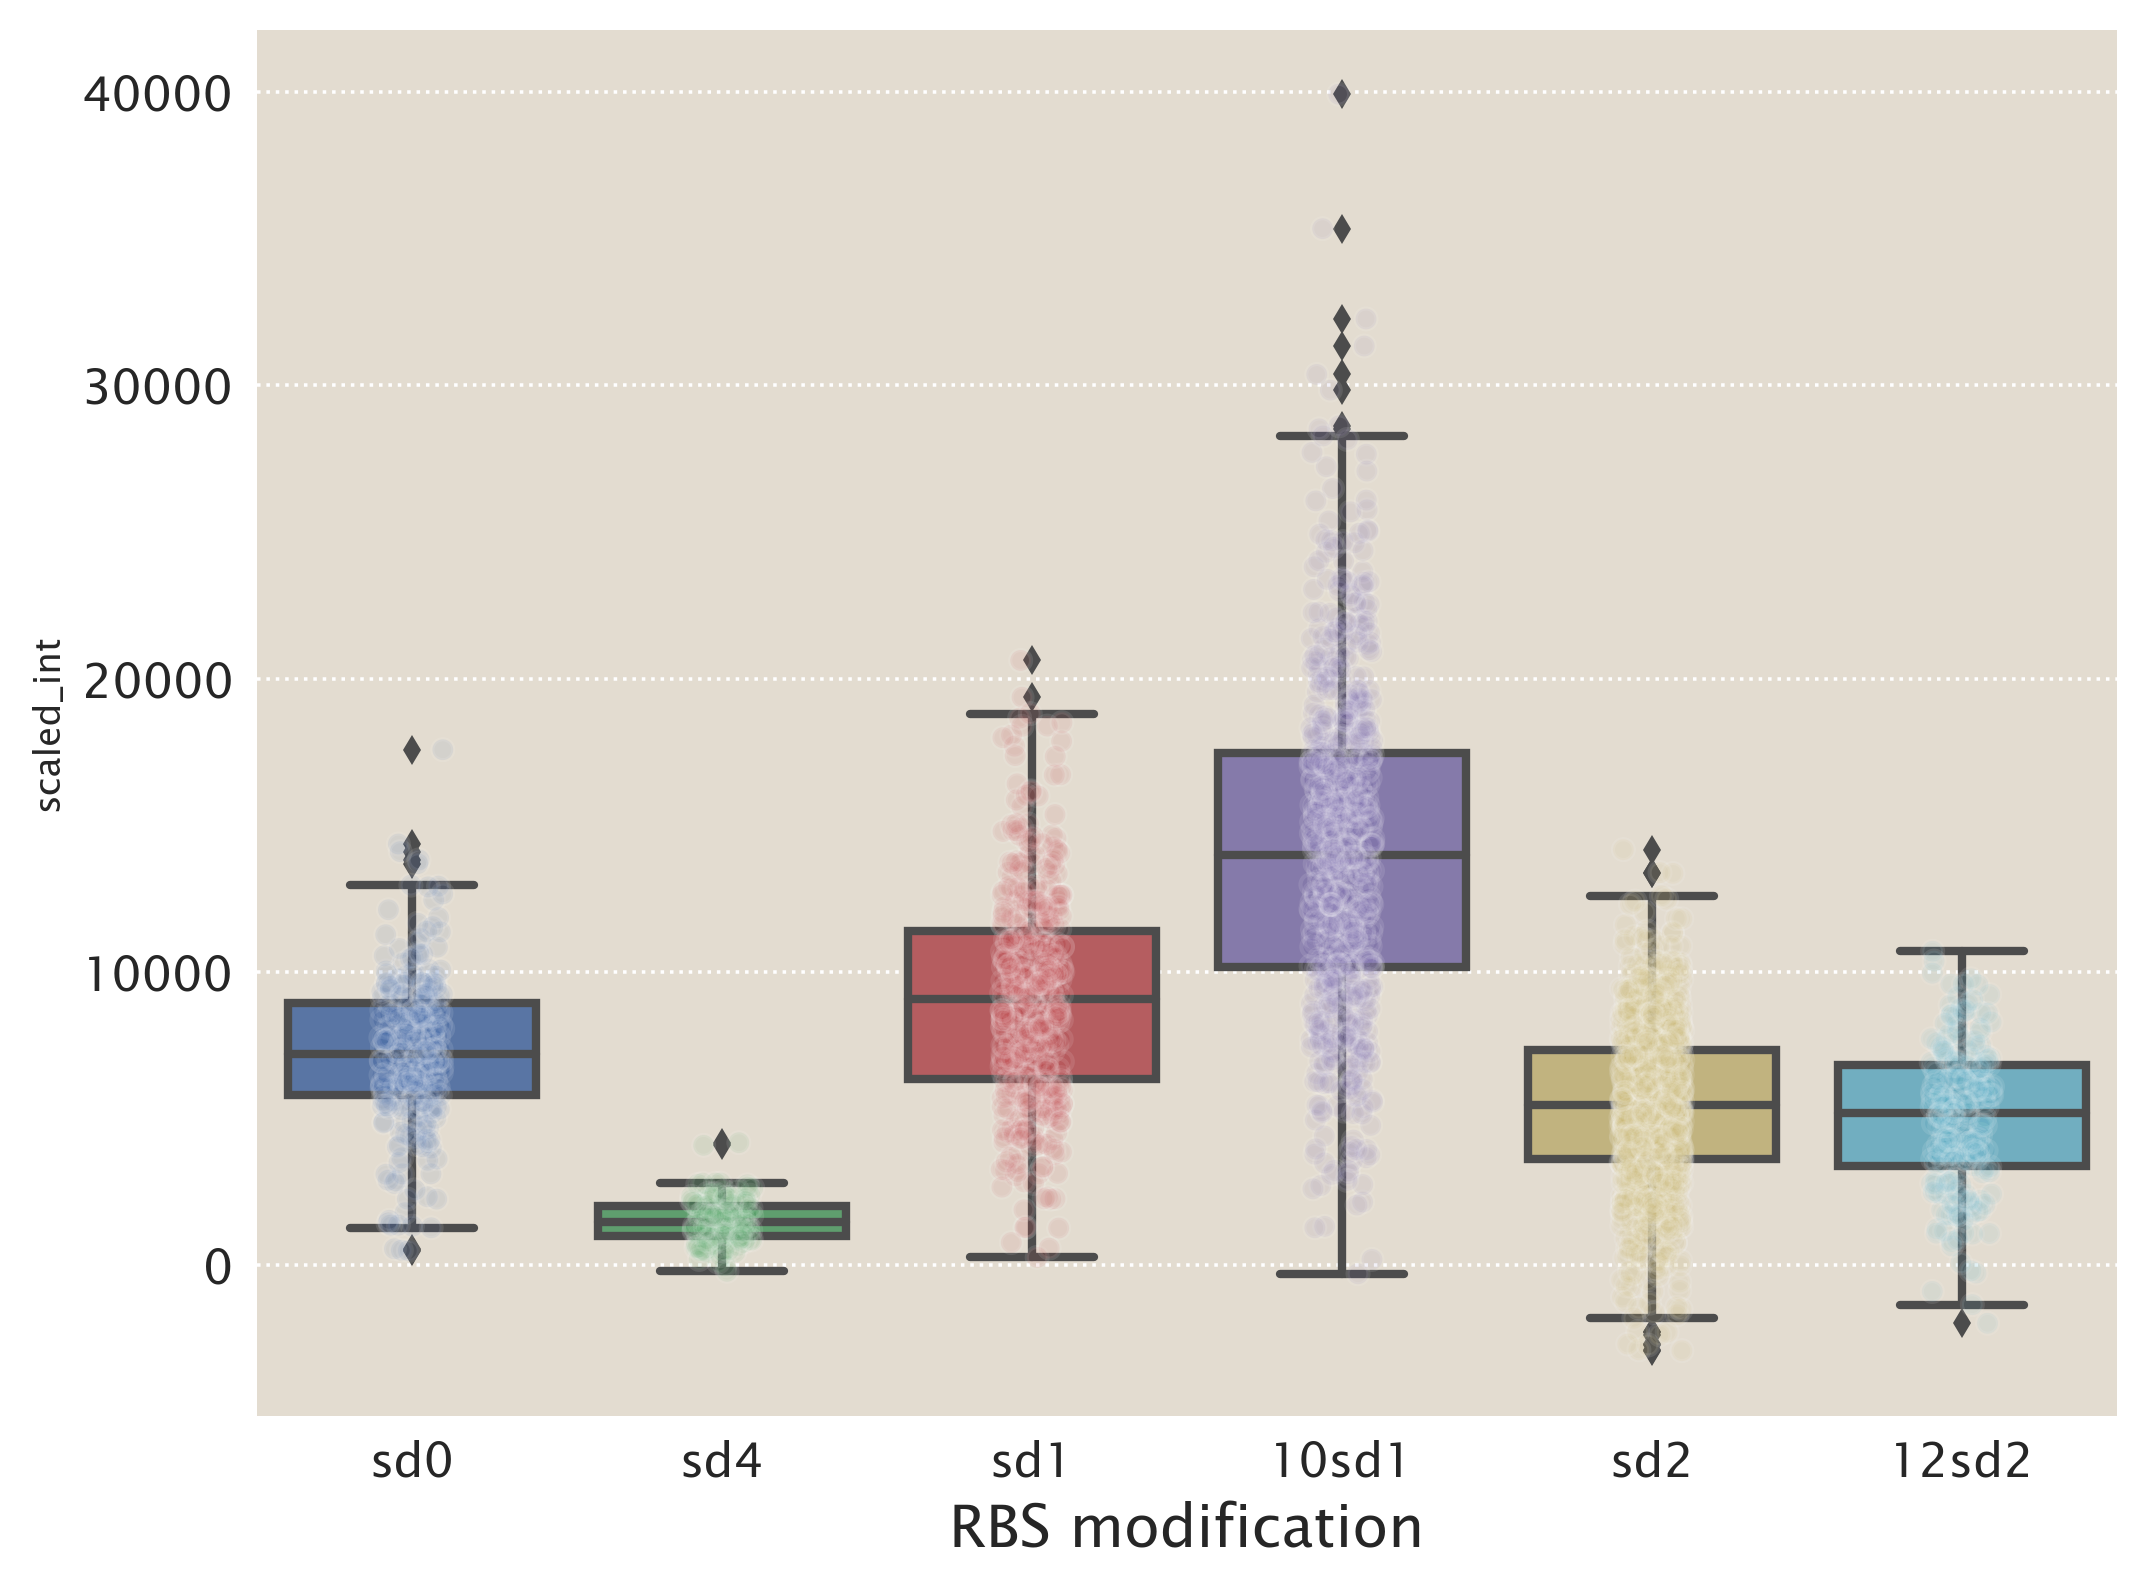

In [147]:
y = 'scaled_int'
sns.stripplot(x='sd', y=y, data=data, jitter=True, alpha=0.1, 
             edgecolor='white', linewidth=1)
sns.boxplot(x='sd', y=y, data=data)
plt.xlabel('RBS modification', fontsize=14)
# plt.ylabel('relative intensity to SD0', fontsize=14)

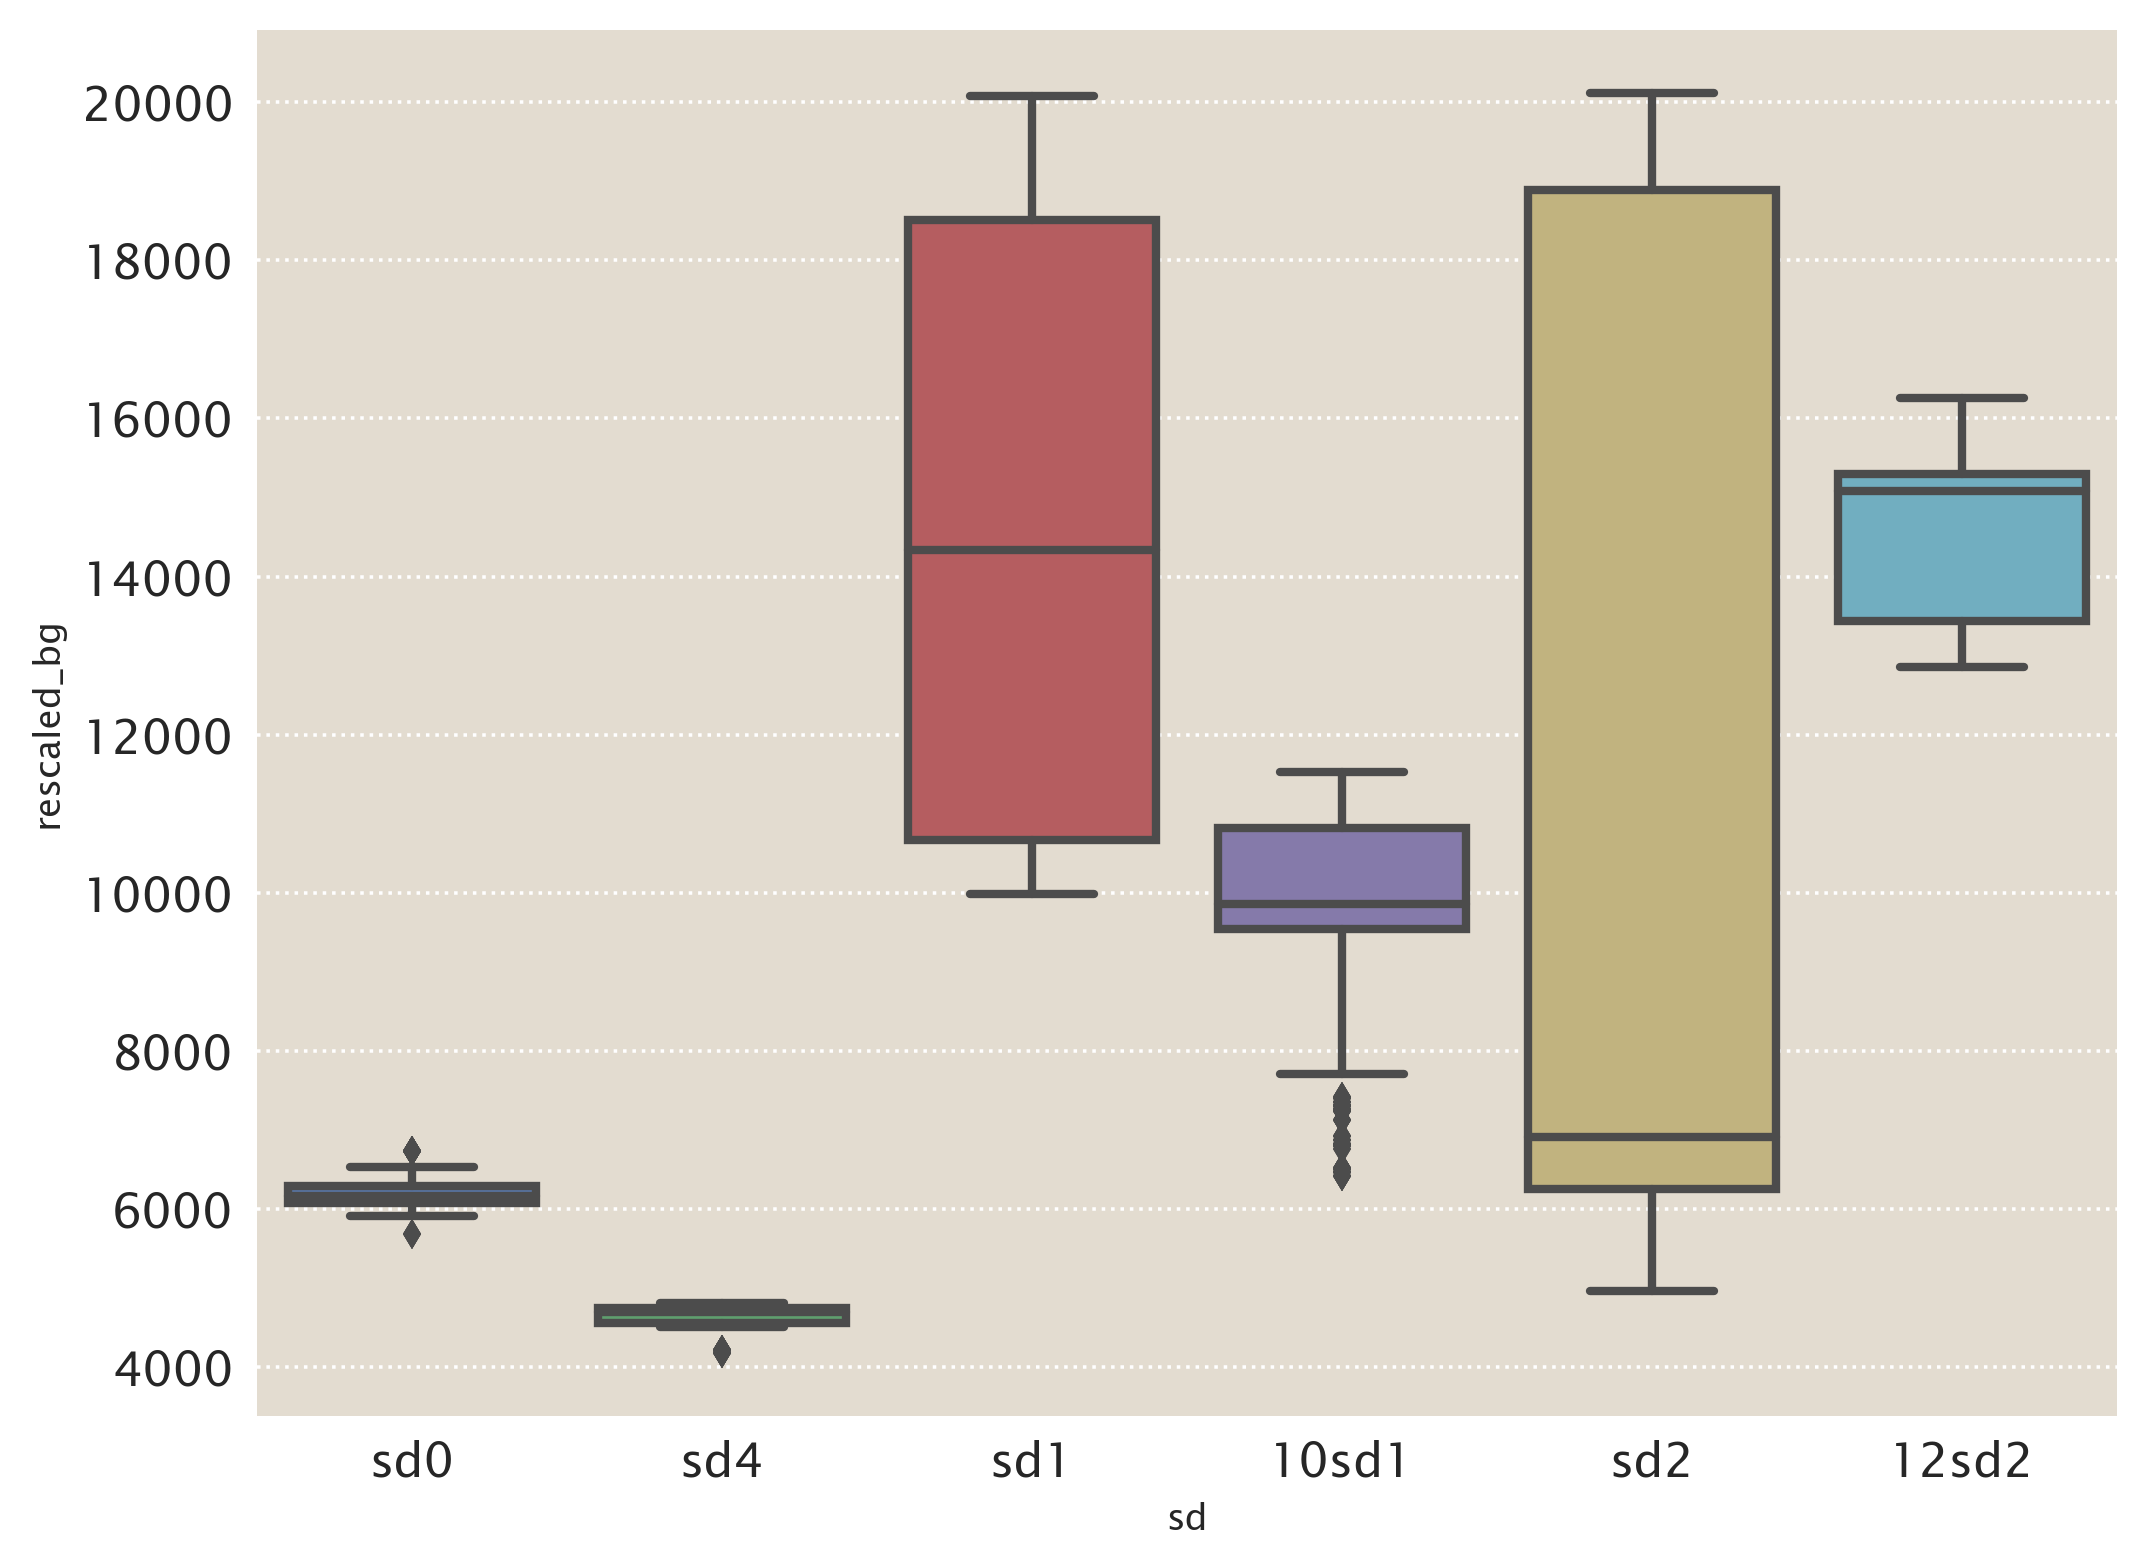

In [149]:
sns.boxplot(x='sd', y='rescaled_bg', data=data)

In [115]:
print(files[4], files_gfp[4])

data/images/12sd2/May18/12SD2_8000ulmin_pre_1/Pos12/img_000000000_Brightfield_000.tif data/images/12sd2/May18/12SD2_8000ulmin_pre_1/Pos12/img_000000000_GFP_000.tif


In [132]:
grouped = data.groupby('sd')
for g, d in grouped:
    print(g, d['exposure_ms'].unique())

10sd1 [25]
12sd2 [50]
sd0 [25]
sd1 [25]
sd2 [50 25]
sd4 [100]


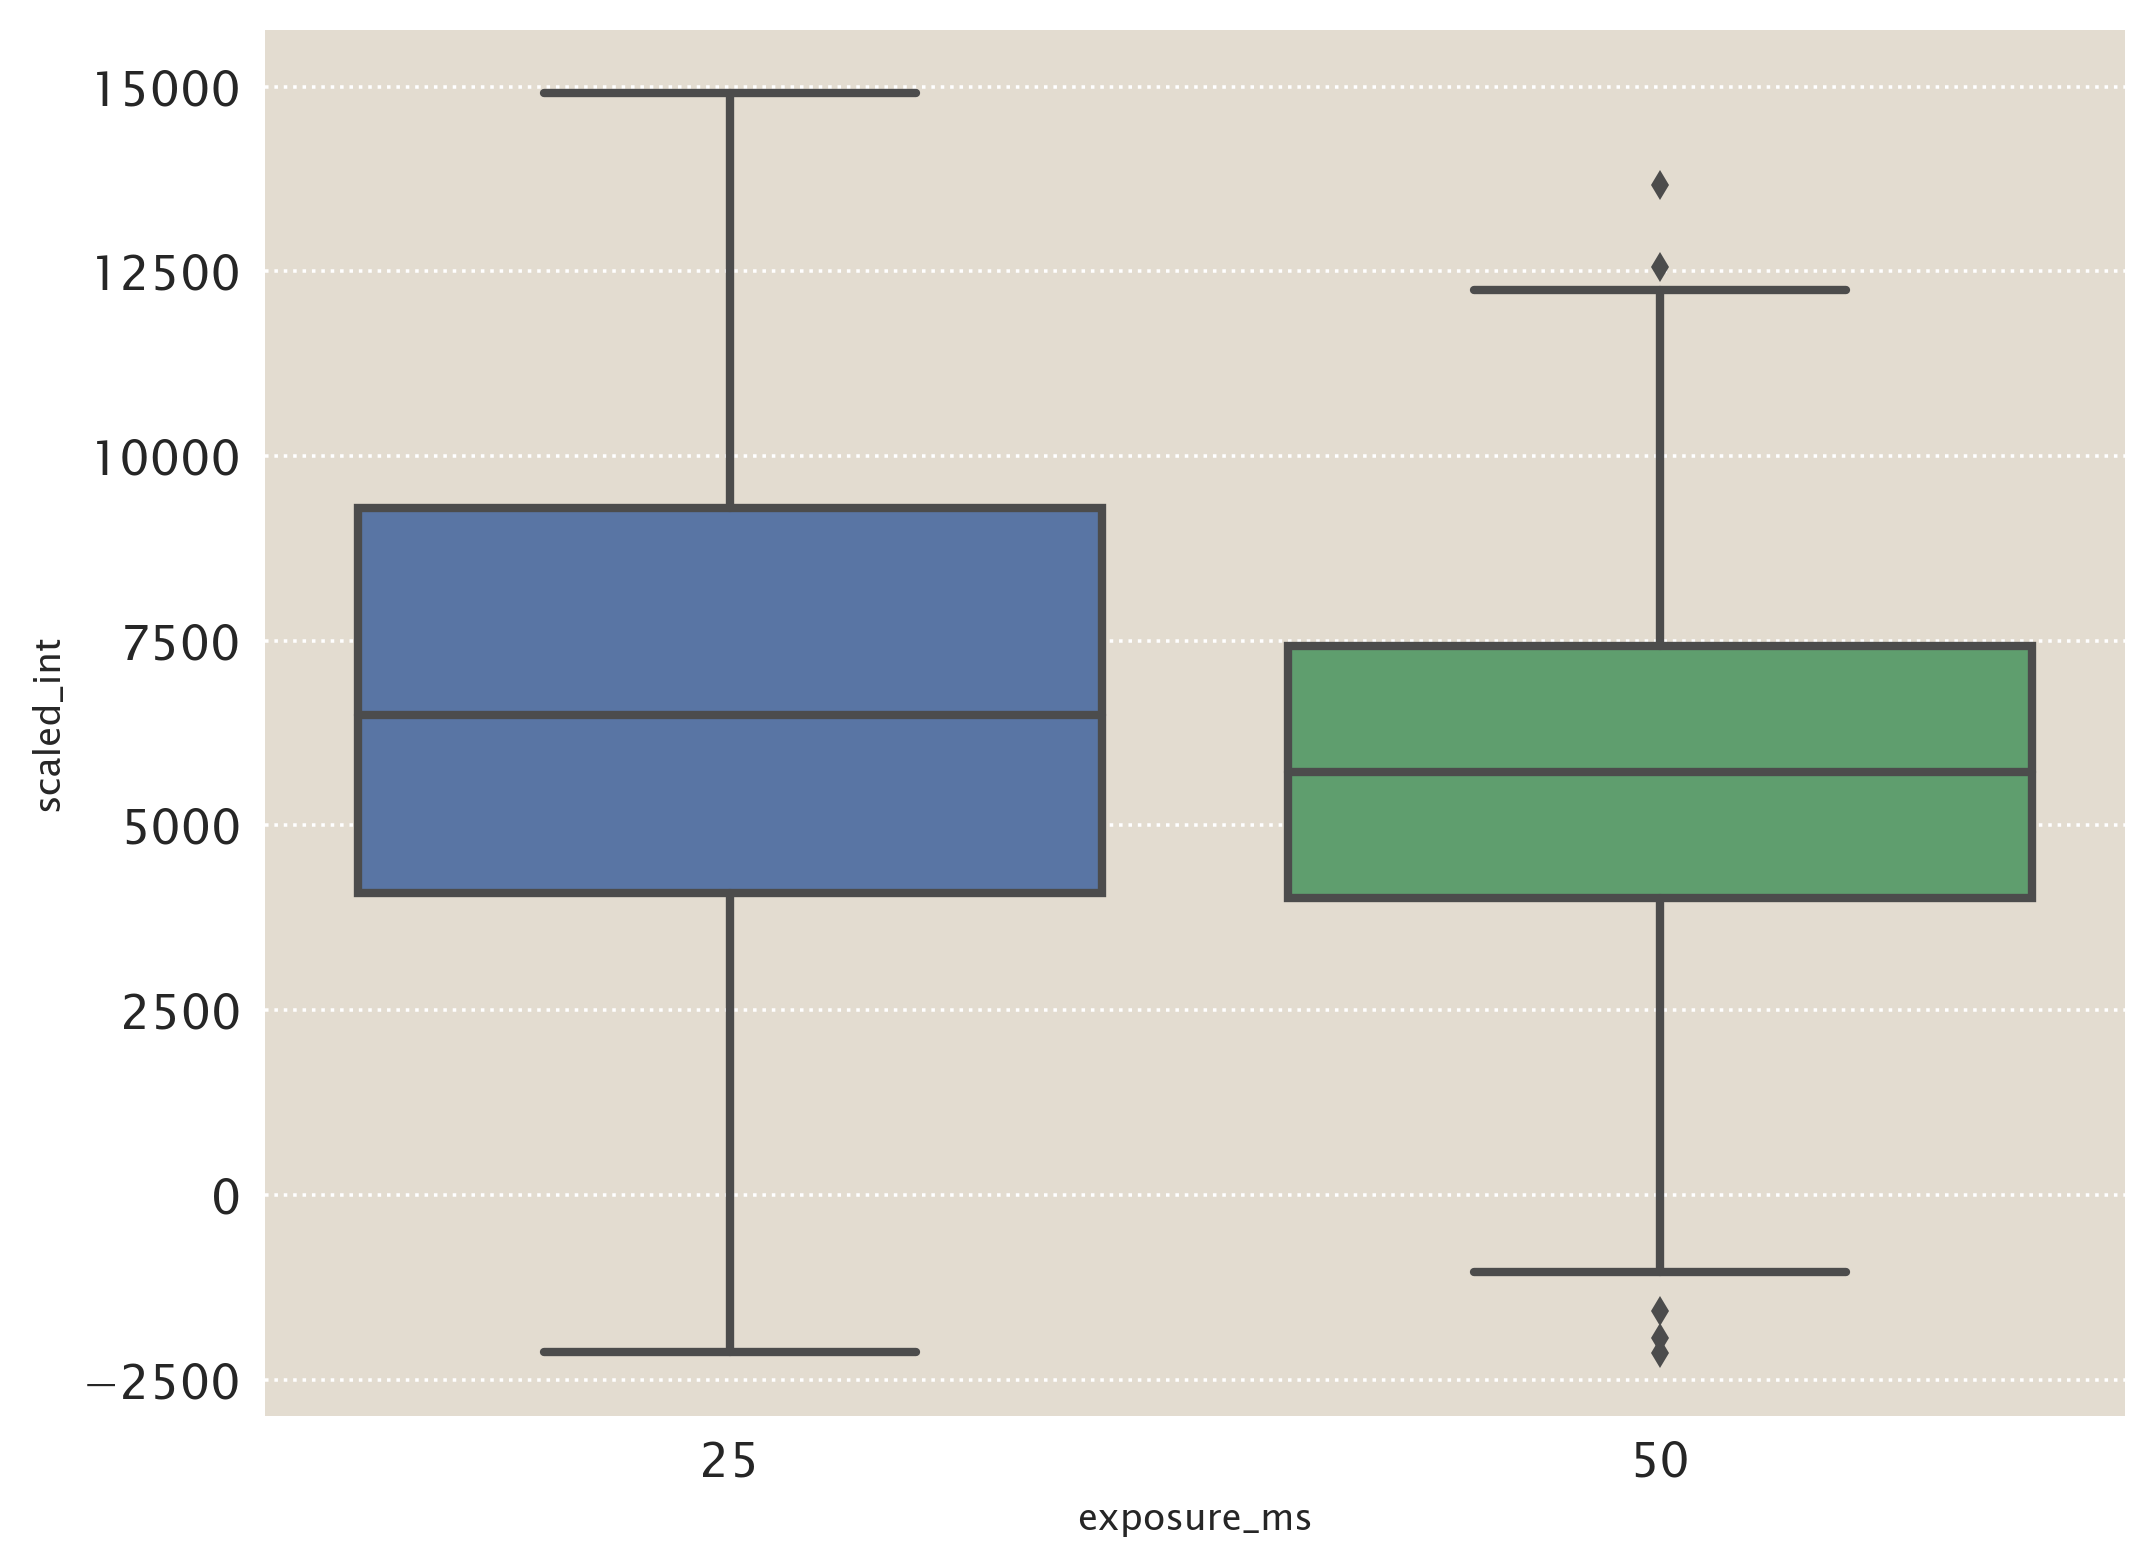

In [133]:
sns.boxplot(x='exposure_ms', y='scaled_int', data=data[data['sd'] == 'sd2'])